In [1]:
%matplotlib inline

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
import json
import nltk
from datetime import datetime
import pymc3 as pm, theano.tensor as tt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
data = pd.read_csv('pnd_features.csv', index_col=0)

In [7]:
# channel id
data['channel'] = data['channel'].factorize()[0]

In [8]:
# interaction variables
data['volume_yobit'] = data['relative_volume'] * data['yobit']
data['coin_yobit'] = data['coin_cap'] * data['yobit']

In [9]:
# dependent and indepenedet variables
y = data['theoretical_return'].values
x = data[['subscriber_0901', 'duration', 'relative_volume','coin_cap', 'volume_yobit', 'coin_yobit']]
dummy = data[['yobit', 'bittrex', 'year']].reset_index(drop=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
ss = StandardScaler()
ss.fit(x)
x_ss = ss.transform(x)
x_ss = pd.DataFrame(x_ss, columns= x.columns)

In [11]:
x = x_ss.merge(dummy,right_index=True, left_index=True)
x = x.reindex(columns=['subscriber_0901', 'duration', 'relative_volume','coin_cap', 'yobit', 'bittrex', 'year', 'volume_yobit', 'coin_yobit'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (3 chains in 1 job)
NUTS: [sigma, eta, tau, beta, intercept]


Sampling 3 chains for 1_000 tune and 7_000 draw iterations (3_000 + 21_000 draws total) took 89 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,-0.008,0.046,-0.095,0.077,0.000,0.000,13505.0,13280.0,13493.0,15318.0,1.0
beta[0],-0.012,0.023,-0.056,0.031,0.000,0.000,19214.0,15314.0,19209.0,16585.0,1.0
beta[1],0.003,0.015,-0.025,0.032,0.000,0.000,33531.0,11300.0,33489.0,16461.0,1.0
beta[2],-0.002,0.013,-0.027,0.022,0.000,0.000,45103.0,8022.0,45009.0,15319.0,1.0
beta[3],-0.004,0.017,-0.036,0.028,0.000,0.000,34557.0,10903.0,34560.0,17047.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
eta[95],-0.016,0.128,-0.254,0.230,0.001,0.001,43882.0,7433.0,43929.0,14505.0,1.0
eta[96],-0.002,0.129,-0.236,0.246,0.001,0.001,47159.0,7586.0,47248.0,14952.0,1.0
eta[97],-0.016,0.127,-0.263,0.217,0.001,0.001,46409.0,7645.0,46412.0,15012.0,1.0
tau,0.141,0.022,0.100,0.183,0.000,0.000,4669.0,4669.0,4569.0,6019.0,1.0


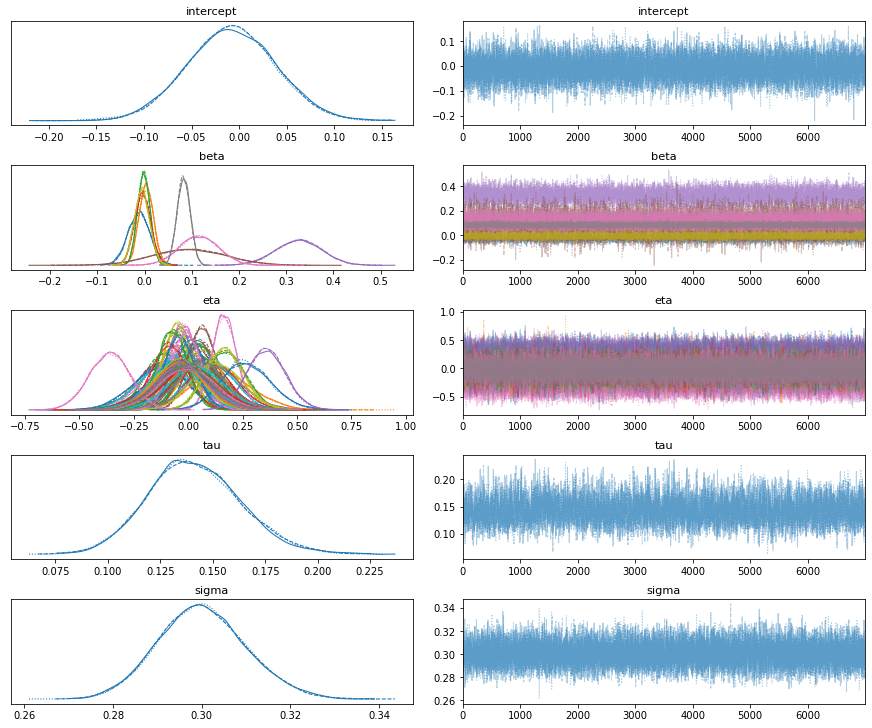

In [12]:
# Normal distribution
n, k  = x.shape
b0 = np.zeros(k)
tau0 = 0.01 * np.eye(k)


with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    coef = pm.MvNormal('beta', mu=b0, tau=tau0, shape=k)
    tau = pm.HalfCauchy('tau', 5)
    eta = pm.Normal('eta', mu=0, sigma=tau, shape=len(data['channel'].unique()))
    eq = intercept +  eta[data['channel'].values] + pm.math.dot(x, coef)

    # gamma glm
    sigma = pm.HalfCauchy('sigma', 5)
    est = pm.Normal('y', mu=eq, sigma= sigma, observed=pm.math.log(y))
    
# sampling
with model:
    # get sample from 101th, two chains
    trace = pm.sample(7000, tune=1000, chains = 3, random_seed=0)
_ = pm.traceplot(trace)
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


1.0
1.0


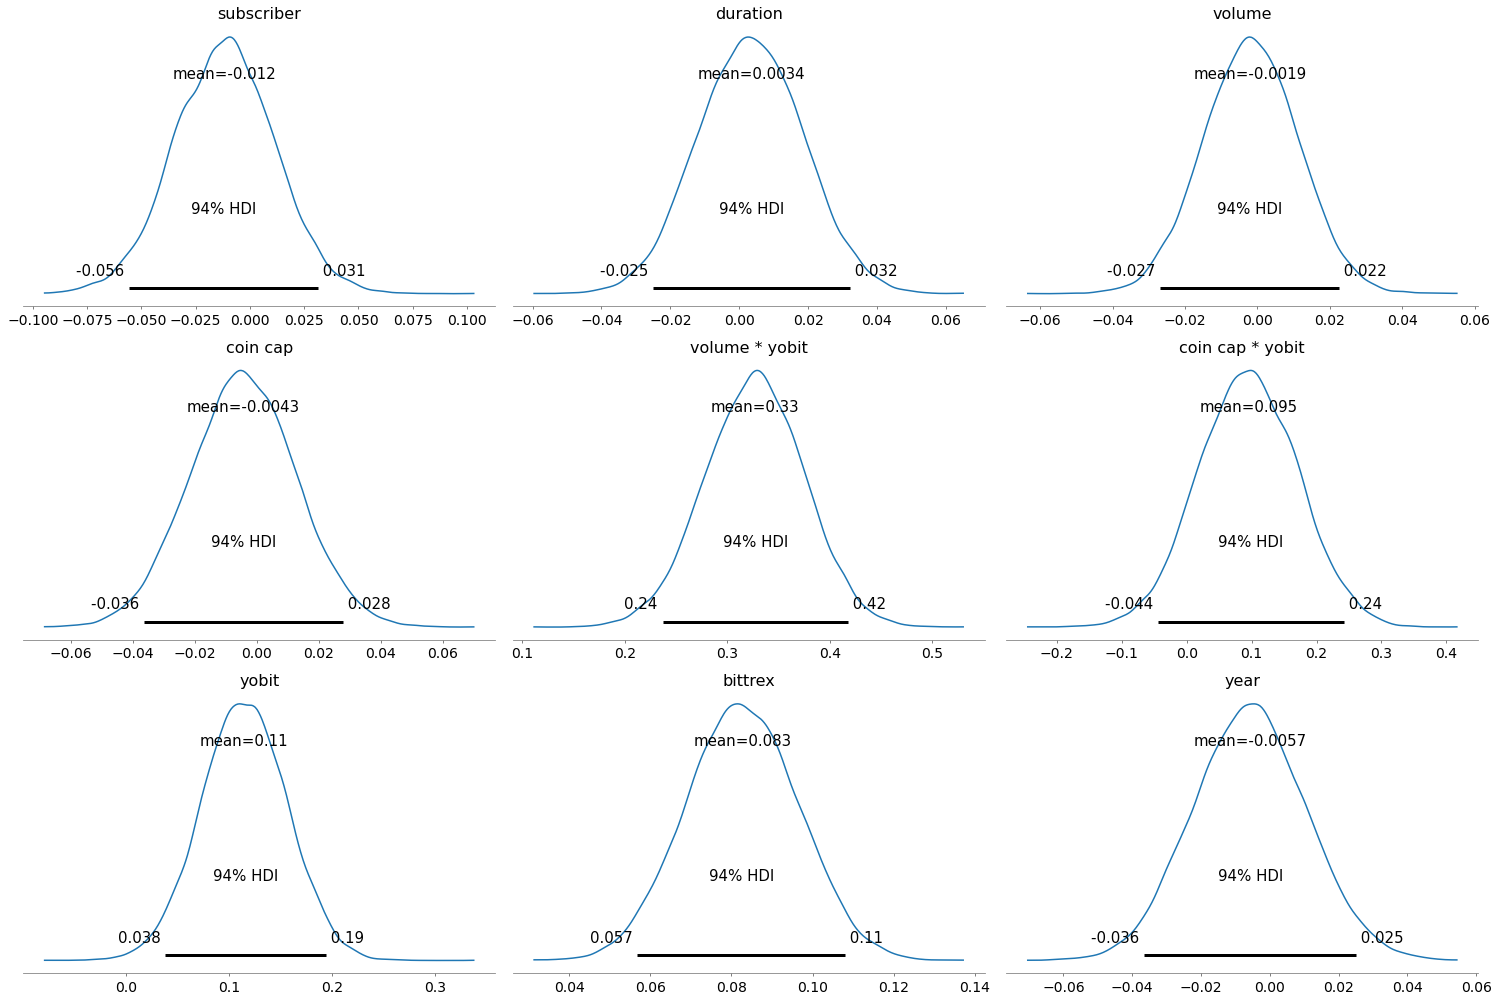

In [13]:
rhat = pm.summary(trace)['r_hat']
print(min(rhat))
print(max(rhat))
var_names = ['subscriber', 'duration', 'volume','coin cap', 'volume * yobit', 'coin cap * yobit','yobit', 'bittrex',  'year',]
sim_param = dict([('{}'.format(var_names[i]), trace['beta'][:,i]) for i in range(k)])
pm.plot_posterior(sim_param, kind='kde', point_estimate='mean')
plt.show()

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


Text(0, 0.5, 'Channel effect')

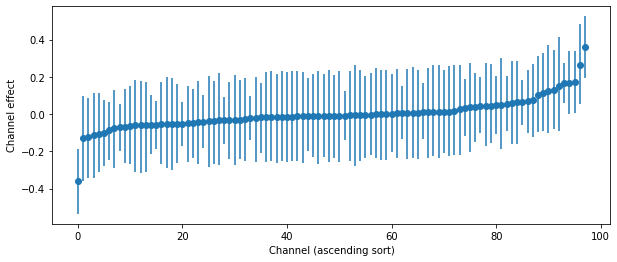

In [14]:
# telegram channel effect ascending order
df_hpd = pd.DataFrame(pm.stats.hpd(trace['eta']),
                      columns=['hpd_low', 'hpd_high'])
df_median = pd.DataFrame(np.quantile(trace['eta'], 0.5, axis=0),
                         columns=['hpd_median'])
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_values(by='hpd_median')
df_hpd = df_hpd.reset_index()

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.index, df_hpd.hpd_median,
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T,
             fmt='o')
axs.set_xlabel('Channel (ascending sort)')
axs.set_ylabel('Channel effect')

In [15]:
betas = []
for i in range(k):
  betas.append('beta[{}]'.format(i))
table = pm.summary(trace).loc[betas]
table.index = var_names
hpd = pm.stats.hpd(trace['beta'])
hpd = pd.DataFrame(hpd, index=var_names, columns=['hpd1', 'hpd2'])
table = table[['mean', 'sd', 'r_hat']].merge(hpd, right_index=True, left_index=True)
pd.options.display.precision = 3
display(table)

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


,mean,sd,r_hat,hpd1,hpd2
subscriber,-0.012,0.023,1.0,-0.056,0.031
duration,0.003,0.015,1.0,-0.025,0.032
volume,-0.002,0.013,1.0,-0.027,0.022
coin cap,-0.004,0.017,1.0,-0.036,0.028
volume * yobit,0.327,0.048,1.0,0.237,0.418
coin cap * yobit,0.095,0.076,1.0,-0.044,0.242
yobit,0.115,0.042,1.0,0.038,0.194
bittrex,0.083,0.014,1.0,0.057,0.108
year,-0.006,0.016,1.0,-0.036,0.025
